# WINCLAP TEST

In [ ]:
# # Descomentar para instalar librerias

# !pip install matplotlib  
# !pip install numpy       
# !pip install pandas      
# !pip install seaborn    
# !pip install sinfo
# !pip install sklearn    

In [ ]:
# Se importan las librerias con las que se va a trabajar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sinfo import sinfo
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

%matplotlib inline

In [ ]:
# Visualizamos el entorno con el que se trabajo y las librerias instaladas

sinfo()

-----
matplotlib  3.2.2
numpy       1.19.5
pandas      1.1.5
seaborn     0.11.1
sinfo       0.3.1
sklearn     0.22.2.post1
-----
IPython             5.5.0
jupyter_client      5.3.5
jupyter_core        4.7.1
notebook            5.3.1
-----
Python 3.7.10 (default, Feb 20 2021, 21:17:23) [GCC 7.5.0]
Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
2 logical CPU cores, x86_64
-----
Session information updated at 2021-03-24 13:58


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Leemos el .csv y lo guardamos en la variable data

data = pd.read_csv('/content/drive/MyDrive/Proyectos DS/Test técnico Winclap/Dataset-WinclapApp-TestDS.csv')

Diccionario de significado de las columnas:

`app_id`= customer unique ID 

`timestamp`= date associated to the campaign report

`platform`= platform where the client sends traffic to (web, android, iOS, etc)

`country`= target country associated to the campaign

`media_source` = channel where the campaign is running (facebook, google, others)

`spend`= amount of investment for that day on the specific campaign

`spend_currency`= currency of the spend (USD, ARS, etc)

`target_event_count` = volume of events obtained by the campaign investment associated to that date

In [ ]:
data.head(10)

,app_id,timestamp,platform,country,media_source,spend,spend_currency,target_event_count
0,winclap.com,9/12/20,android,AU,pinterest,100.00,USD,2
1,winclap.com,12/6/20,android,AU,pinterest,300.00,USD,9
2,winclap.com,12/5/20,android,AU,pinterest,300.00,USD,1
3,winclap.com,12/4/20,android,AU,pinterest,300.00,USD,5
4,winclap.com,9/11/20,android,AU,pinterest,100.00,USD,2
5,winclap.com,12/3/20,android,AU,pinterest,297.59,USD,8
6,winclap.com,12/7/20,android,AU,pinterest,299.40,USD,10
7,winclap.com,9/14/20,android,AU,pinterest,100.00,USD,1
8,winclap.com,9/19/20,android,AU,pinterest,100.00,USD,2
9,winclap.com,9/15/20,android,AU,pinterest,100.00,USD,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118 entries, 0 to 3117
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   app_id              3118 non-null   object 
 1   timestamp           3118 non-null   object 
 2   platform            3118 non-null   object 
 3   country             3118 non-null   object 
 4   media_source        3118 non-null   object 
 5   spend               3118 non-null   float64
 6   spend_currency      3118 non-null   object 
 7   target_event_count  3118 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 195.0+ KB


Vemos el tipo de datos de las features y observamos ademas que no hay valores nulos o faltantes.

In [ ]:
data.describe(percentiles=[.05, .25, .5, .75, .95])

,spend,target_event_count
count,3118.000000,3118.000000
mean,448.109064,12.751123
std,1044.176914,23.445983
min,0.230000,1.000000
5%,10.116500,1.000000
25%,60.597500,2.000000
50%,172.475000,5.000000
75%,378.527500,13.000000
95%,1527.950500,47.000000
max,10536.780000,225.000000


Hay valores altos para `spend` y `target_event_count` con respecto al 95% de los datos

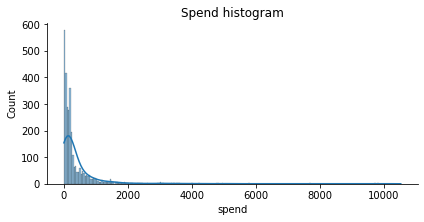

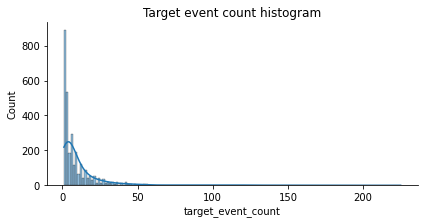

In [ ]:
sns.displot(data.spend, kde=True, height=3, aspect=2)
plt.title('Spend histogram')
sns.displot(data.target_event_count, kde=True, height=3, aspect=2)
plt.title('Target event count histogram')

plt.show();

Se puede observar en el histograma o grafico de densidades, que hay muchos eventos en los valores cercanos al cero para las features `spend` y `target_event_count`

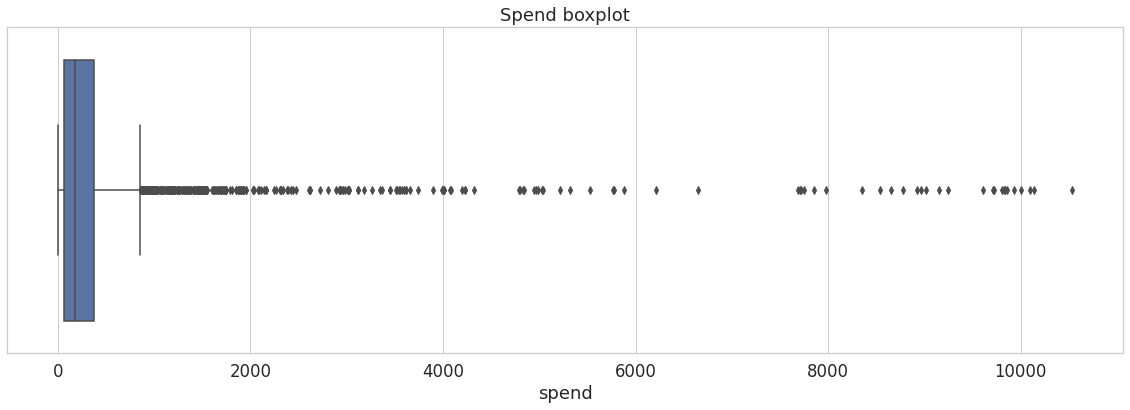

In [ ]:
sns.set(rc={'figure.figsize':(20,6)}, font_scale=1.5, style='whitegrid')
sns.boxplot(x=data.spend);
plt.title('Spend boxplot');

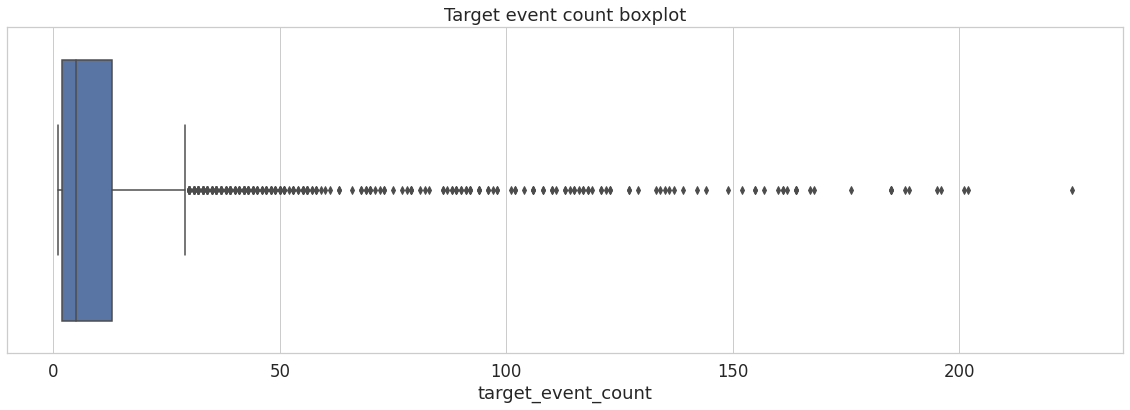

In [ ]:
sns.boxplot(x=data.target_event_count);
plt.title('Target event count boxplot');

Los boxplots nos muestran que hay valores atipicos u outliers para:


> Valores iguales o mayores a 1400 aproximadamente en `spend`


> Valores iguales o mayores a 30 aproximadamente en `target_event_count`





In [ ]:
# Se restauran los valores de default para seaborn

sns.reset_defaults()

In [ ]:
data.nunique()

app_id                   1
timestamp              101
platform                 1
country                  3
media_source             5
spend                 2554
spend_currency           1
target_event_count     133
dtype: int64

Hay features o columnas que solo tienen un valor. Se quitaran del modelo posterior para que el mismo pueda generalizar mejor

In [ ]:
data.country.unique()

array(['AU', 'UK', 'US'], dtype=object)

In [ ]:
data.media_source.unique()

array(['pinterest', 'facebook', 'googleshopping', 'google',
       'googledisplay'], dtype=object)

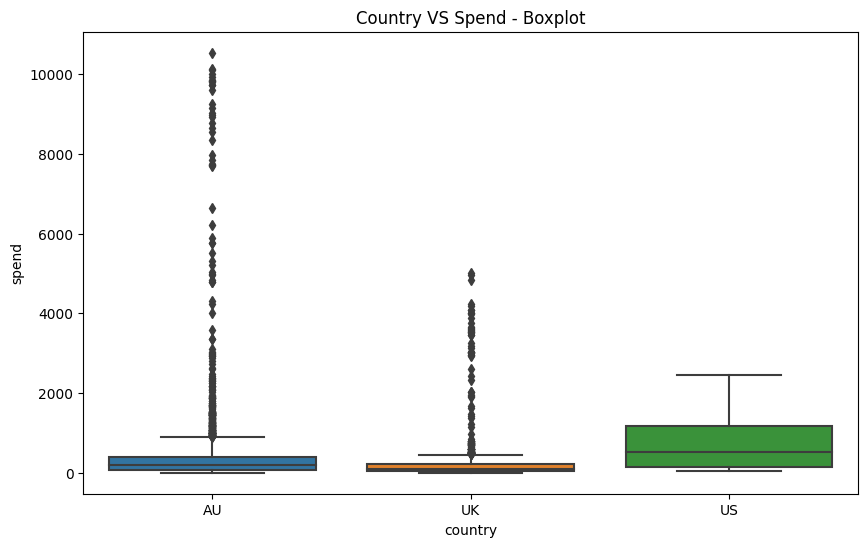

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='country', y='spend', data=data);
plt.title('Country VS Spend - Boxplot');

Los valores atipicos de `spend` se dan en los paises como AU y UK. Ademas el `spend` en estos, son inferiores a US. 

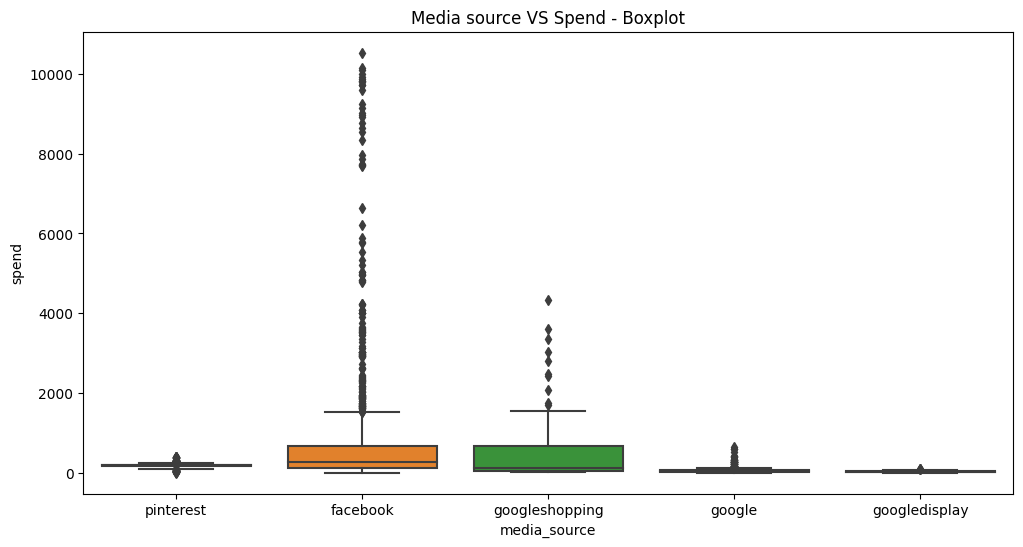

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='media_source', y='spend', data=data);
plt.title('Media source VS Spend - Boxplot');

El `spend` es mayor en plataformas como Facebook y Google Shopping

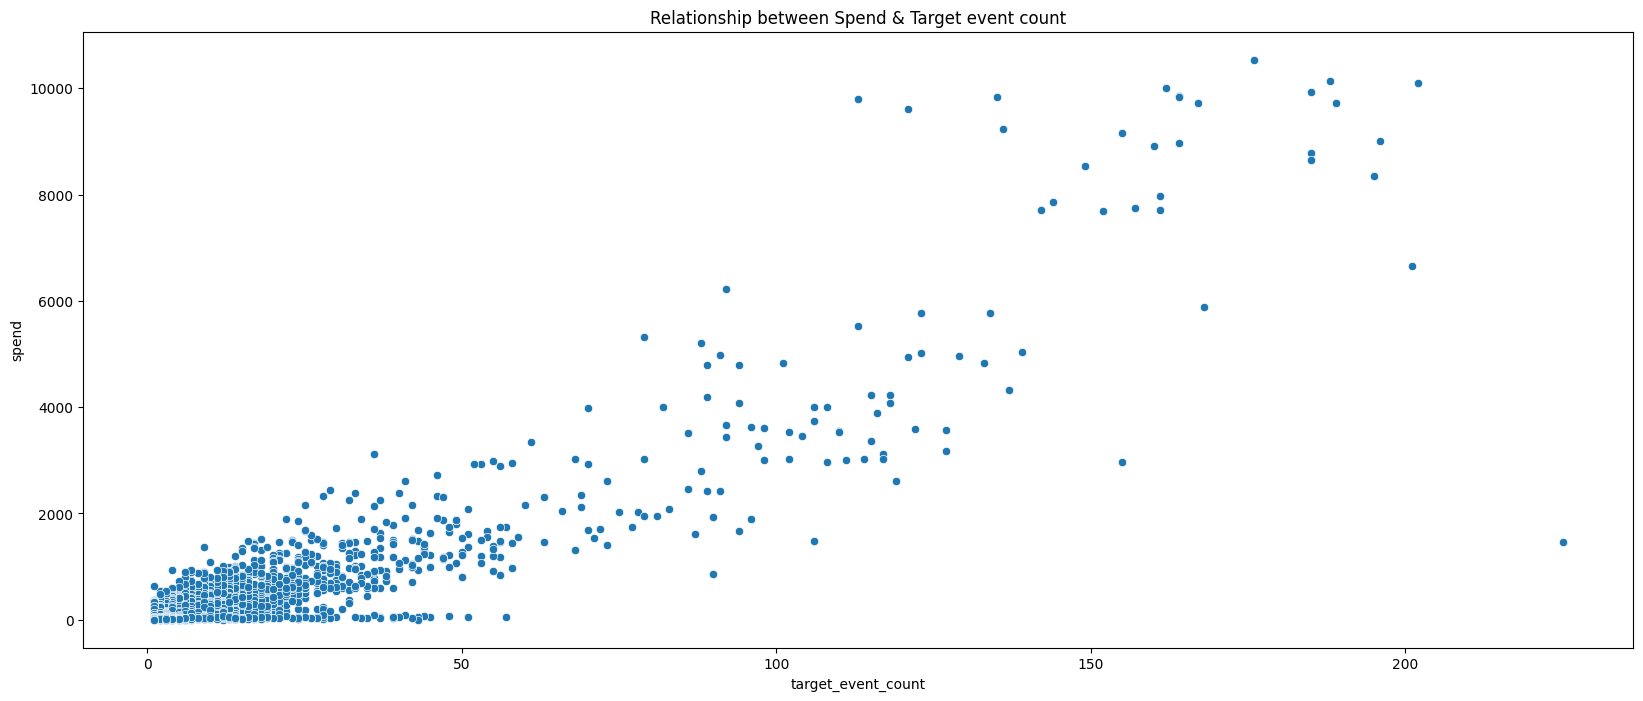

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend);
plt.title('Relationship between Spend & Target event count');

In [ ]:
data.corr()

,spend,target_event_count
spend,1.000000,0.901125
target_event_count,0.901125,1.000000


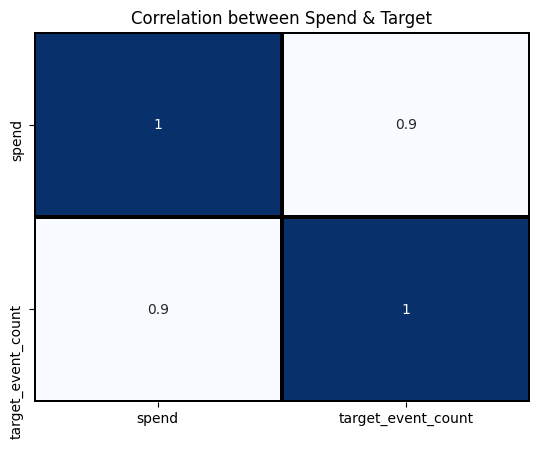

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap='Blues', cbar=False, linecolor='Black', linewidths=2)
plt.title('Correlation between Spend & Target');

Se puede notar que hay una correlacion entre `spend` y `target_event_count`. Por lo tanto, a mayor gasto, mayor cantidad de eventos.

Visualizando el scatterplot, se nota que hay outliers en las regiones donde el gasto es mayor pero la cantidad de eventos es menor o la cantidad de eventos es mayor pero el gasto es menor.

--------------------

In [ ]:
data.media_source.value_counts()

facebook          1700
pinterest          620
google             550
googleshopping     200
googledisplay       48
Name: media_source, dtype: int64

Hay 2 o 3 veces mas cantidad de valores en la plataforma Facebook que las demas

In [ ]:
# Se agrupan los datos en relacion al media_source

media_group = data.groupby(data.media_source)

In [ ]:
media_group.get_group('google').describe(percentiles=[.05, .25, .5, .75, .95])

,spend,target_event_count
count,550.000000,550.000000
mean,55.176055,6.883636
std,79.464990,9.090173
min,0.230000,1.000000
5%,1.839000,1.000000
25%,12.005000,2.000000
50%,33.515000,3.000000
75%,58.305000,8.000000
95%,211.454500,27.550000
max,653.630000,57.000000


In [ ]:
media_group.get_group('facebook').describe(percentiles=[.05, .25, .5, .75, .95])

,spend,target_event_count
count,1700.000000,1700.000000
mean,681.616853,17.363529
std,1344.679798,29.081317
min,1.810000,1.000000
5%,34.358000,1.000000
25%,106.072500,3.000000
50%,265.395000,8.000000
75%,673.537500,17.000000
95%,2622.640000,78.050000
max,10536.780000,225.000000


In [ ]:
media_group.get_group('pinterest').describe(percentiles=[.05, .25, .5, .75, .95])

,spend,target_event_count
count,620.000000,620.000000
mean,187.957629,4.783871
std,66.989800,4.045987
min,1.610000,1.000000
5%,98.989000,1.000000
25%,159.927500,2.000000
50%,200.000000,4.000000
75%,200.000000,6.000000
95%,299.520500,12.000000
max,400.000000,31.000000


In [ ]:
media_group.get_group('googledisplay').describe(percentiles=[.05, .25, .5, .75, .95])

,spend,target_event_count
count,48.000000,48.000000
mean,30.893958,1.729167
std,21.243853,0.916505
min,1.160000,1.000000
5%,3.291000,1.000000
25%,16.952500,1.000000
50%,25.685000,1.000000
75%,40.550000,2.000000
95%,75.628000,3.650000
max,82.580000,4.000000


In [ ]:
media_group.get_group('googleshopping').describe(percentiles=[.05, .25, .5, .75, .95])

,spend,target_event_count
count,200.000000,200.000000
mean,450.459700,17.025000
std,680.735434,24.257504
min,2.470000,1.000000
5%,16.306500,1.000000
25%,38.210000,2.000000
50%,105.205000,4.000000
75%,658.735000,26.000000
95%,1543.906000,68.150000
max,4318.280000,137.000000


In [ ]:
list(media_group.groups)

['facebook', 'google', 'googledisplay', 'googleshopping', 'pinterest']

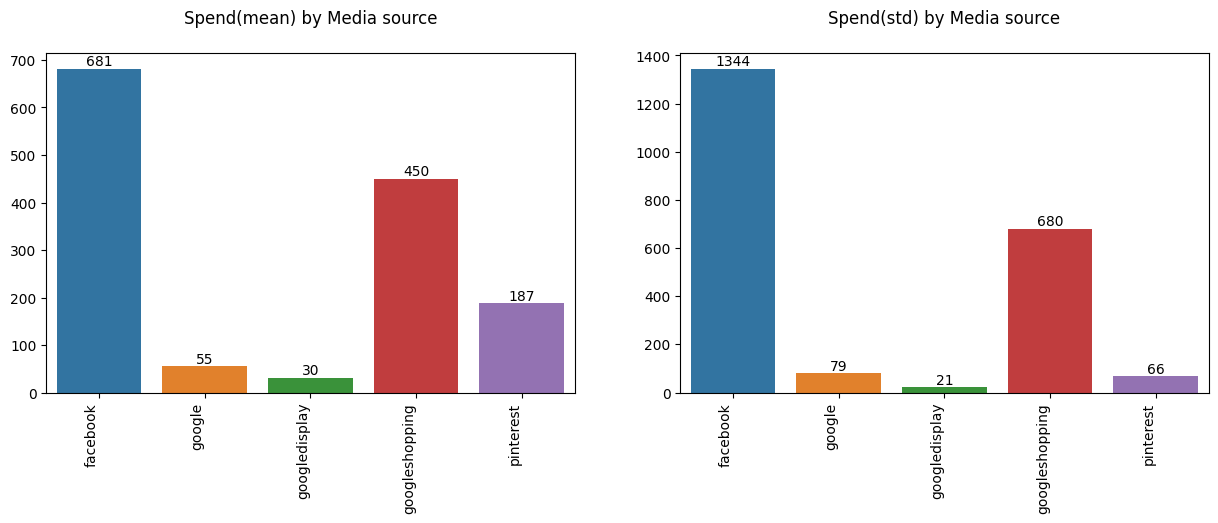

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

ax = sns.barplot(x=list(media_group.groups), y= media_group.spend.mean(), ax=axes[0])
ax.title.set_text('Spend(mean) by Media source\n')
ax.set_ylabel('')

ax1 = sns.barplot(x=list(media_group.groups), y= media_group.spend.std(), ax=axes[1])
ax1.title.set_text('Spend(std) by Media source\n')
ax1.set_ylabel('')

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');
    
for rect in ax1.patches:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

f.autofmt_xdate(rotation=90)

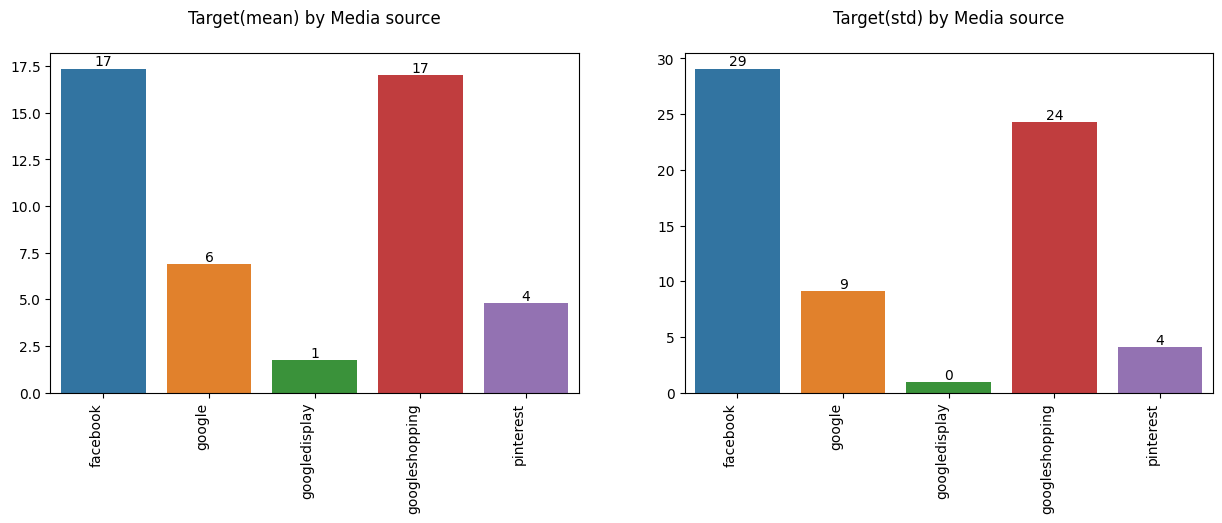

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

ax = sns.barplot(x=list(media_group.groups), y= media_group.target_event_count.mean(), ax=axes[0])
ax.title.set_text('Target(mean) by Media source\n')
ax.set_ylabel('')

ax1 = sns.barplot(x=list(media_group.groups), y= media_group.target_event_count.std(), ax=axes[1])
ax1.title.set_text('Target(std) by Media source\n')
ax1.set_ylabel('')

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');
    
for rect in ax1.patches:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

f.autofmt_xdate(rotation=90)

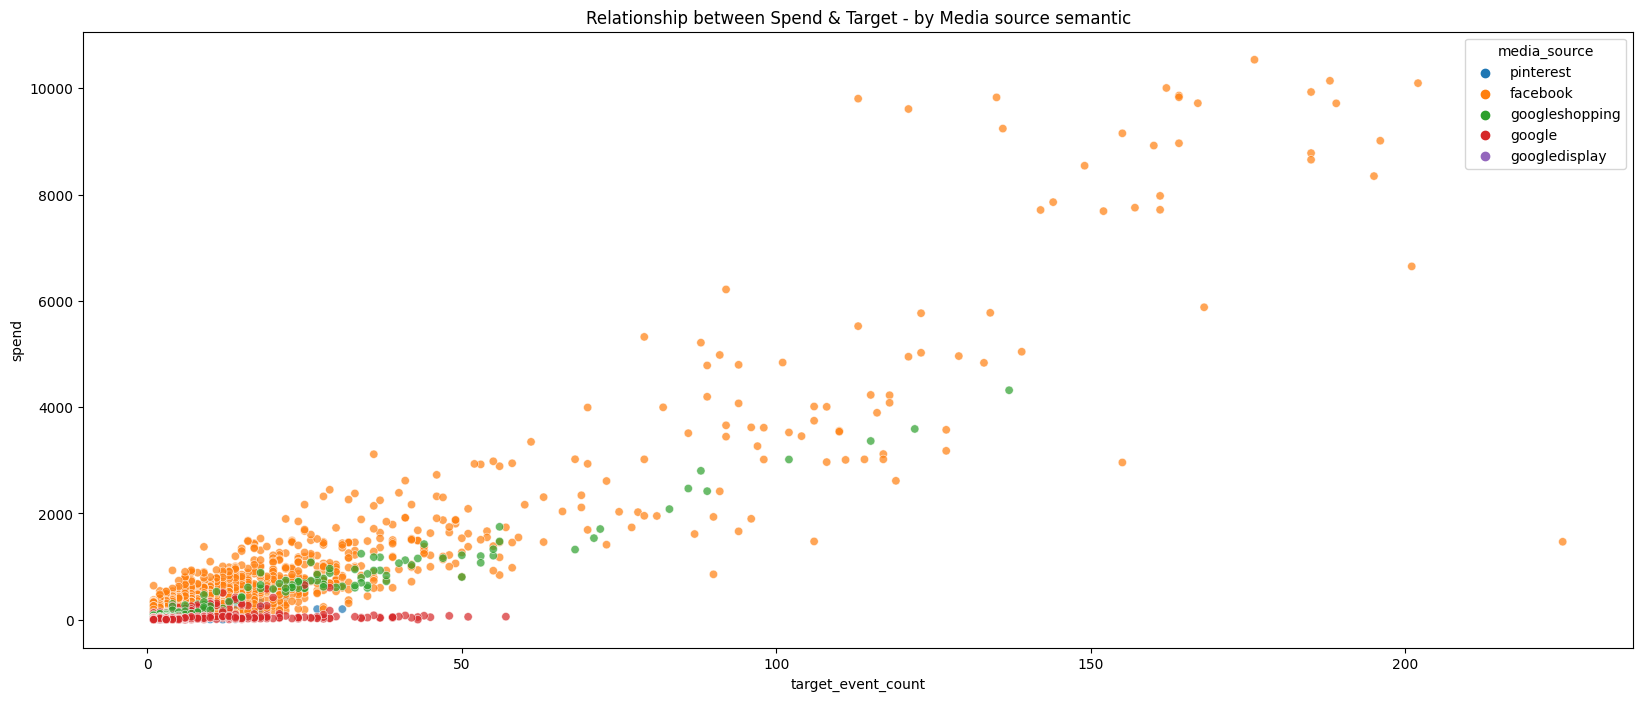

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=data.media_source, alpha=.7);
plt.title('Relationship between Spend & Target - by Media source semantic');

Mediante los plots podemos ver que hay una mayor cantidad de eventos y gastos en plataformas como Facebook y Google Shopping.

Hay valores atipicos en plataformas como Google debido a que aumenta la cantidad de eventos pero los gastos son bajos.

----------------

In [ ]:
data.country.value_counts()

AU    2266
UK     763
US      89
Name: country, dtype: int64

Hay mucha cantidad de datos para el pais AU

In [ ]:
# Se agrupan los datos en relacion al country

country_group = data.groupby(data.country)

In [ ]:
list(country_group.groups)

['AU', 'UK', 'US']

In [ ]:
country_group.get_group('AU').describe(percentiles=[.05, .25, .5, .75, .95])

,spend,target_event_count
count,2266.000000,2266.000000
mean,474.983363,12.591792
std,1132.724356,23.763101
min,0.230000,1.000000
5%,8.820000,1.000000
25%,65.177500,2.000000
50%,200.000000,5.000000
75%,402.240000,13.000000
95%,1498.727500,44.000000
max,10536.780000,225.000000


In [ ]:
country_group.get_group('UK').describe(percentiles=[.05, .25, .5, .75, .95])

,spend,target_event_count
count,763.000000,763.000000
mean,338.453473,13.348624
std,768.153511,23.630502
min,1.160000,1.000000
5%,13.914000,1.000000
25%,50.470000,3.000000
50%,99.420000,6.000000
75%,213.875000,12.000000
95%,1950.640000,77.700000
max,5022.970000,155.000000


In [ ]:
country_group.get_group('US').describe(percentiles=[.05, .25, .5, .75, .95])

,spend,target_event_count
count,89.000000,89.000000
mean,703.952360,11.685393
std,544.379401,9.836846
min,33.940000,1.000000
5%,147.546000,1.000000
25%,156.110000,5.000000
50%,529.530000,10.000000
75%,1159.900000,17.000000
95%,1529.242000,26.400000
max,2445.490000,57.000000


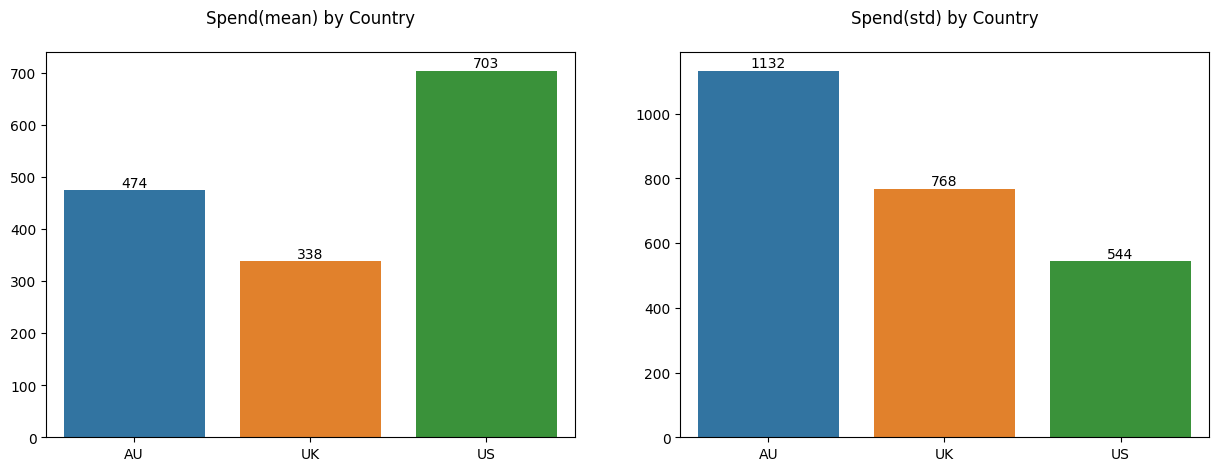

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

ax = sns.barplot(x=list(country_group.groups), y= country_group.spend.mean(), ax=axes[0])
ax.title.set_text('Spend(mean) by Country\n')
ax.set_ylabel('')

ax1 = sns.barplot(x=list(country_group.groups), y= country_group.spend.std(), ax=axes[1])
ax1.title.set_text('Spend(std) by Country\n')
ax1.set_ylabel('')

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');
    
for rect in ax1.patches:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

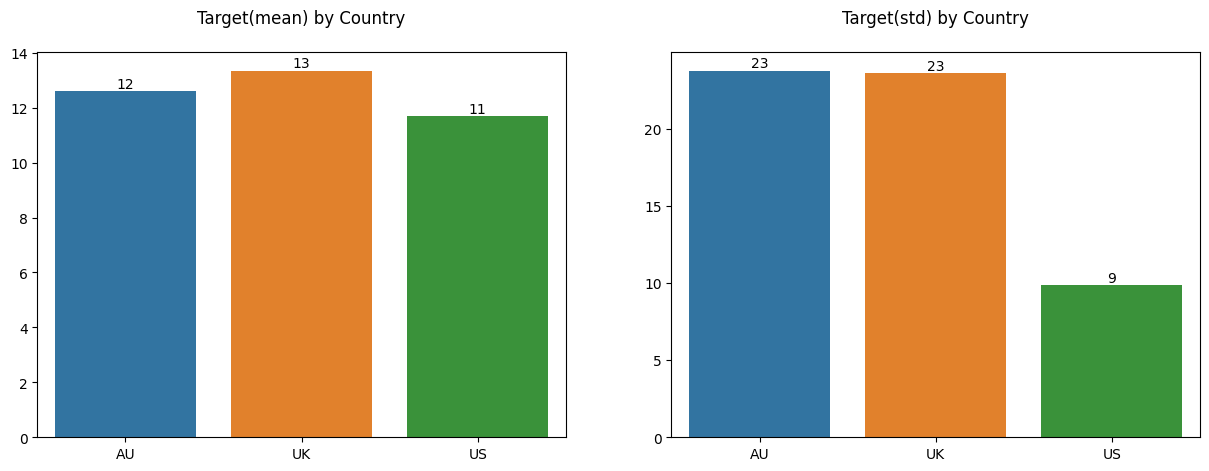

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

ax = sns.barplot(x=list(country_group.groups), y= country_group.target_event_count.mean(), ax=axes[0])
ax.title.set_text('Target(mean) by Country\n')
ax.set_ylabel('')

ax1 = sns.barplot(x=list(country_group.groups), y= country_group.target_event_count.std(), ax=axes[1])
ax1.title.set_text('Target(std) by Country\n')
ax1.set_ylabel('')

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');
    
for rect in ax1.patches:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

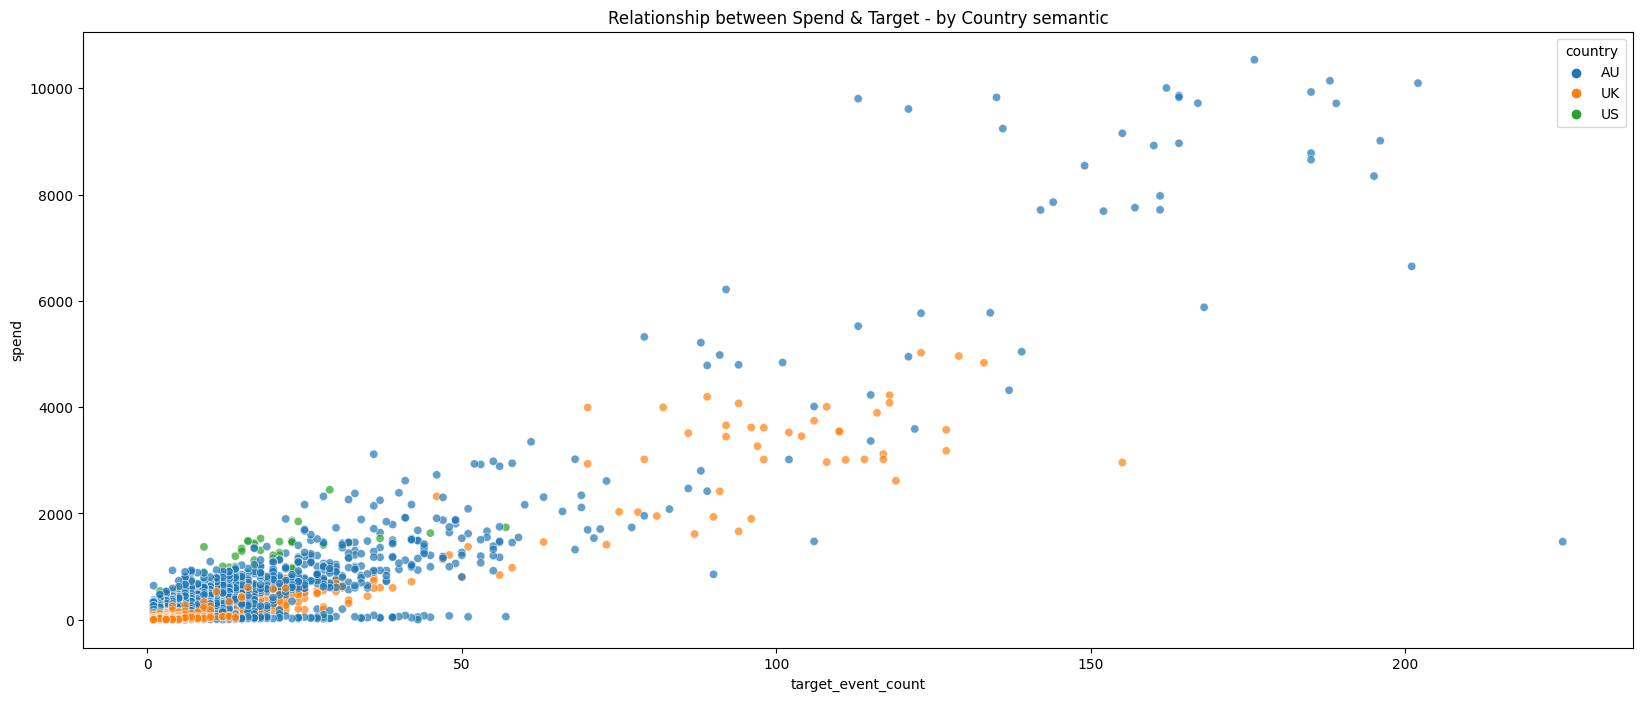

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=data.country, alpha=.7);
plt.title('Relationship between Spend & Target - by Country semantic');

Se puede ver que hay un mayor gasto promedio en US y una baja o normal cantidad de eventos en el mismo. 

En paises como AU y UK, hay un menor gasto promedio con gran variacion de los mismos. Ademas, hay una gran cantidad de sucesos.

---------------

In [ ]:
# Se realiza un split del timestamp entre dias, meses y años. Nos quedamos solo con los meses

time = data.timestamp.str.split(pat='/', expand=True)[0]

In [ ]:
time.value_counts()

11    1141
10     811
9      775
12     391
Name: 0, dtype: int64

Hay una mayor cantidad de valores para el mes de noviembre

In [ ]:
# Se agrupan los datos en base a los meses

time_group = data.groupby(time)

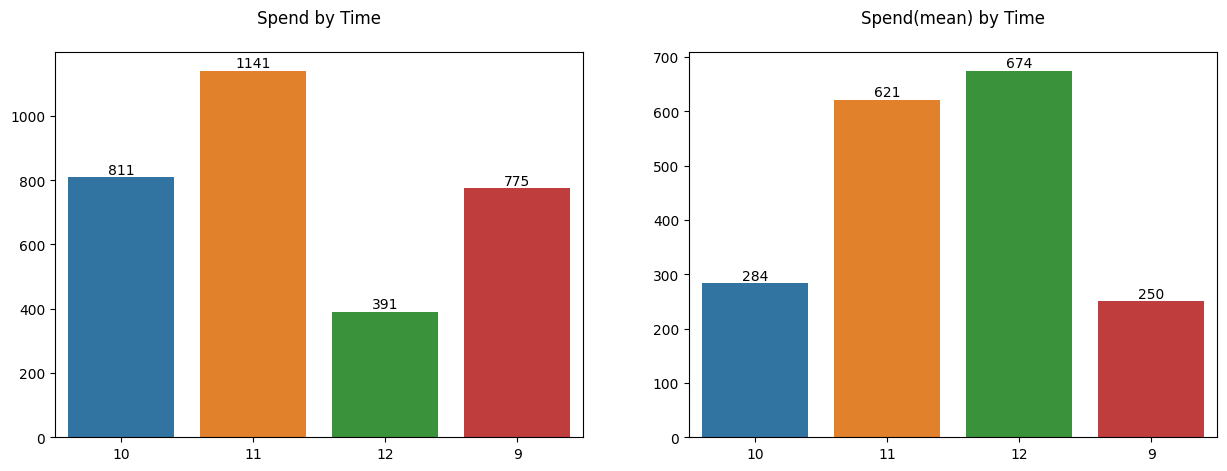

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

ax = sns.barplot(x=list(time_group.groups), y= time_group.spend.count(), ax=axes[0])
ax.title.set_text('Spend by Time\n')
ax.set_ylabel('')

ax1 = sns.barplot(x=list(time_group.groups), y= time_group.spend.mean(), ax=axes[1])
ax1.title.set_text('Spend(mean) by Time\n')
ax1.set_ylabel('')

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');
    
for rect in ax1.patches:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),ha='center', va='bottom');

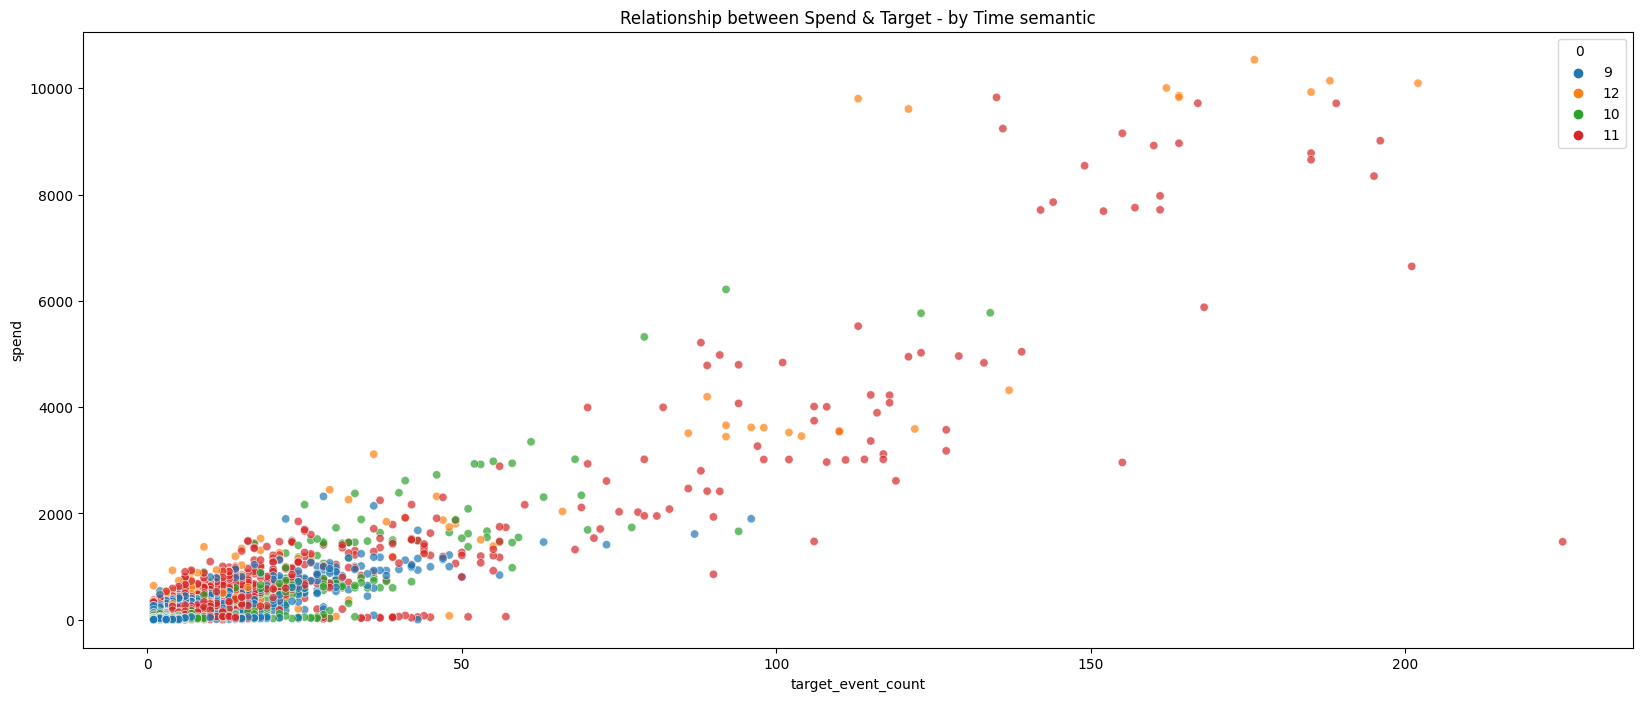

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=time, alpha=.7);
plt.title('Relationship between Spend & Target - by Time semantic');

Mediante los graficos podemos ver que hay una mayor cantidad valores para los meses de octubre y noviembres pero hay un mayor gasto promedio en los meses de noviembre y diciembre

----------------------------------

In [ ]:
data.columns

Index(['app_id', 'timestamp', 'platform', 'country', 'media_source', 'spend',
       'spend_currency', 'target_event_count'],
      dtype='object')

In [ ]:
data_outliers = data[['country', 'media_source', 'spend', 'target_event_count']].copy()

In [ ]:
data_outliers['month'] = time

In [ ]:
data_outliers

,country,media_source,spend,target_event_count,month
0,AU,pinterest,100.00,2,9
1,AU,pinterest,300.00,9,12
2,AU,pinterest,300.00,1,12
3,AU,pinterest,300.00,5,12
4,AU,pinterest,100.00,2,9
...,...,...,...,...,...
3113,UK,google,2.37,1,9
3114,UK,google,2.22,3,9
3115,UK,google,6.03,4,9
3116,UK,google,3.44,3,9


Se agrego la columna month al dataset y se quitaron aquellas que tenian un unico valor

------------------------

In [ ]:
df_outliers = pd.get_dummies(data_outliers, columns=['country', 'media_source', 'month'])
df_outliers

,spend,target_event_count,country_AU,country_UK,country_US,media_source_facebook,media_source_google,media_source_googledisplay,media_source_googleshopping,media_source_pinterest,month_10,month_11,month_12,month_9
0,100.00,2,1,0,0,0,0,0,0,1,0,0,0,1
1,300.00,9,1,0,0,0,0,0,0,1,0,0,1,0
2,300.00,1,1,0,0,0,0,0,0,1,0,0,1,0
3,300.00,5,1,0,0,0,0,0,0,1,0,0,1,0
4,100.00,2,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,2.37,1,0,1,0,0,1,0,0,0,0,0,0,1
3114,2.22,3,0,1,0,0,1,0,0,0,0,0,0,1
3115,6.03,4,0,1,0,0,1,0,0,0,0,0,0,1
3116,3.44,3,0,1,0,0,1,0,0,0,0,0,0,1


In [ ]:
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118 entries, 0 to 3117
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   spend                        3118 non-null   float64
 1   target_event_count           3118 non-null   int64  
 2   country_AU                   3118 non-null   uint8  
 3   country_UK                   3118 non-null   uint8  
 4   country_US                   3118 non-null   uint8  
 5   media_source_facebook        3118 non-null   uint8  
 6   media_source_google          3118 non-null   uint8  
 7   media_source_googledisplay   3118 non-null   uint8  
 8   media_source_googleshopping  3118 non-null   uint8  
 9   media_source_pinterest       3118 non-null   uint8  
 10  month_10                     3118 non-null   uint8  
 11  month_11                     3118 non-null   uint8  
 12  month_12                     3118 non-null   uint8  
 13  month_9           

In [ ]:
df1_outliers = pd.get_dummies(data_outliers, columns=['country', 'media_source'])
df1_outliers['month'] = pd.to_numeric(df1_outliers['month'])
df1_outliers

,spend,target_event_count,month,country_AU,country_UK,country_US,media_source_facebook,media_source_google,media_source_googledisplay,media_source_googleshopping,media_source_pinterest
0,100.00,2,9,1,0,0,0,0,0,0,1
1,300.00,9,12,1,0,0,0,0,0,0,1
2,300.00,1,12,1,0,0,0,0,0,0,1
3,300.00,5,12,1,0,0,0,0,0,0,1
4,100.00,2,9,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3113,2.37,1,9,0,1,0,0,1,0,0,0
3114,2.22,3,9,0,1,0,0,1,0,0,0
3115,6.03,4,9,0,1,0,0,1,0,0,0
3116,3.44,3,9,0,1,0,0,1,0,0,0


In [ ]:
df1_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118 entries, 0 to 3117
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   spend                        3118 non-null   float64
 1   target_event_count           3118 non-null   int64  
 2   month                        3118 non-null   int64  
 3   country_AU                   3118 non-null   uint8  
 4   country_UK                   3118 non-null   uint8  
 5   country_US                   3118 non-null   uint8  
 6   media_source_facebook        3118 non-null   uint8  
 7   media_source_google          3118 non-null   uint8  
 8   media_source_googledisplay   3118 non-null   uint8  
 9   media_source_googleshopping  3118 non-null   uint8  
 10  media_source_pinterest       3118 non-null   uint8  
dtypes: float64(1), int64(2), uint8(8)
memory usage: 97.6 KB


Se elaboraron 2 datasets y pasaron las variables categoricas a dummies para evitar que el algoritmo de clustering asigne peso a alguna variable.

Las diferencias entre los 2 datasets radican en que, al primero se le aplico un dummies a la columna month, mientras que, al segundo se lo convirtio a valor numerico. Esto servira para testear el desempeño del algoritmo en ambos datasets.

--------------------------

## One Class SVM

Es un algoritmo basado en SVM (Support Vector Machine). Es de aprendizaje no supervisado o clustering.

Se entrena con los datos y establece los limites de los puntos. Aquellos que se encuentran fuera de los mismos, se clasifican en outliers

In [ ]:
clf = OneClassSVM(kernel='rbf', 
                  nu=0.013,
                  gamma=.00001)

In [ ]:
outliers = clf.fit_predict(df_outliers)
outliers1 = clf.fit_predict(df1_outliers)

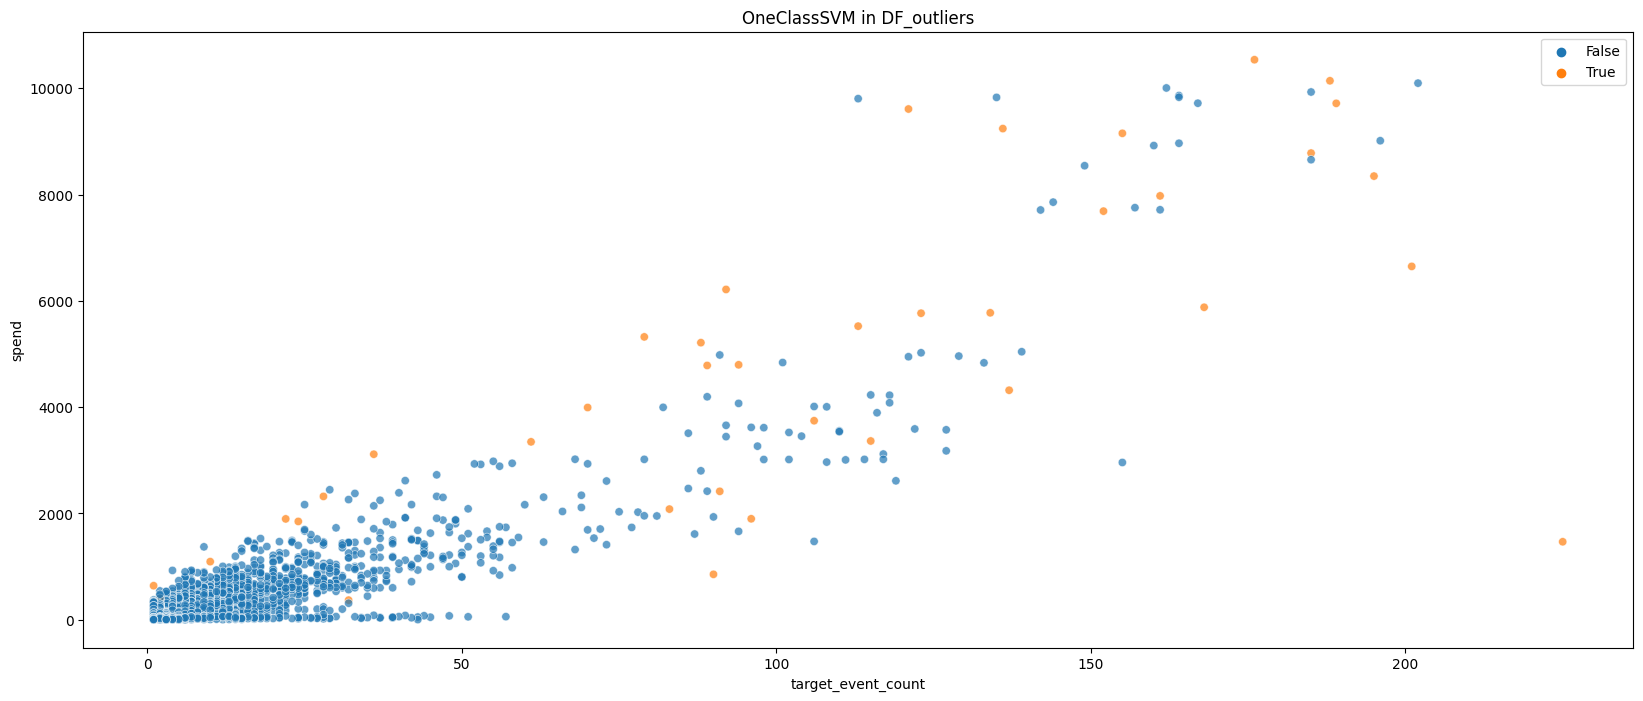

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=outliers==-1, alpha=.7);
plt.title('OneClassSVM in DF_outliers');

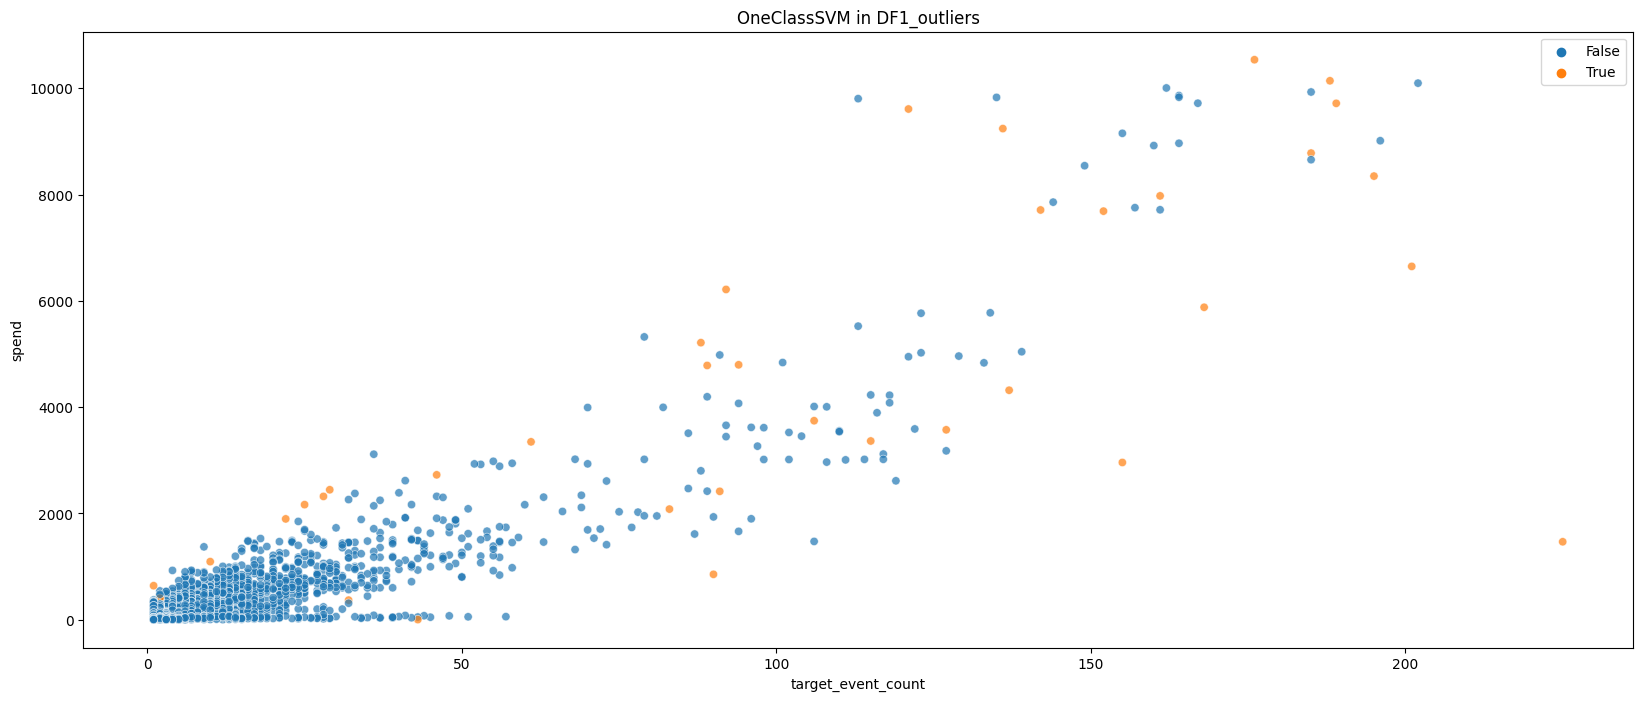

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=outliers1==-1, alpha=.7);
plt.title('OneClassSVM in DF1_outliers');

----

## Elliptic Envelope

Es un algoritmo que se ajusta a una estimación de covarianza robusta a los datos y, por lo tanto, ajusta una elipse a los puntos de datos centrales, ignorando los puntos fuera del modo central.


In [ ]:
cov = EllipticEnvelope(random_state=42)

In [ ]:
outliers = cov.fit_predict(df_outliers)
outliers1 = cov.fit_predict(df1_outliers)

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


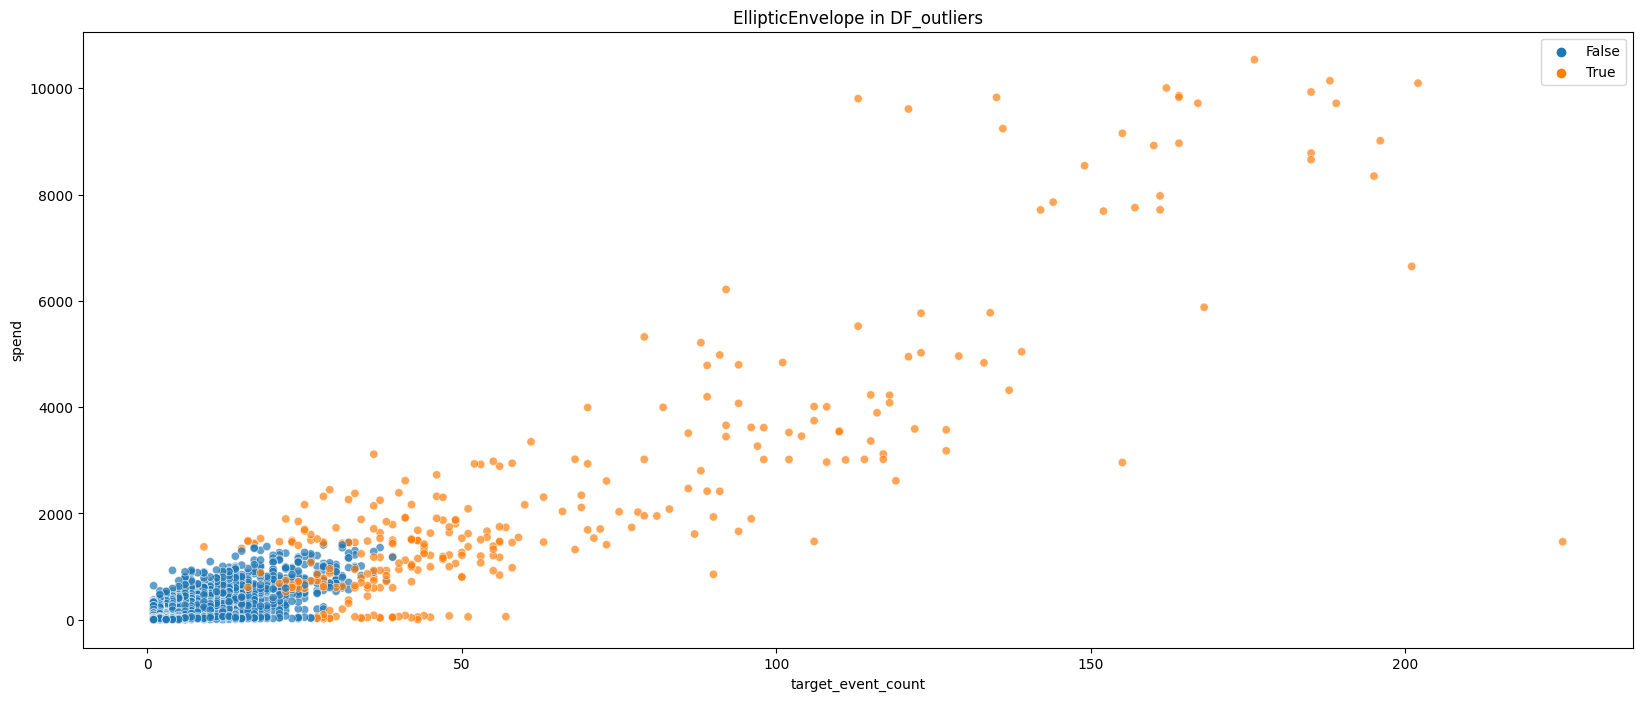

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=outliers==-1, alpha=.7);
plt.title('EllipticEnvelope in DF_outliers');

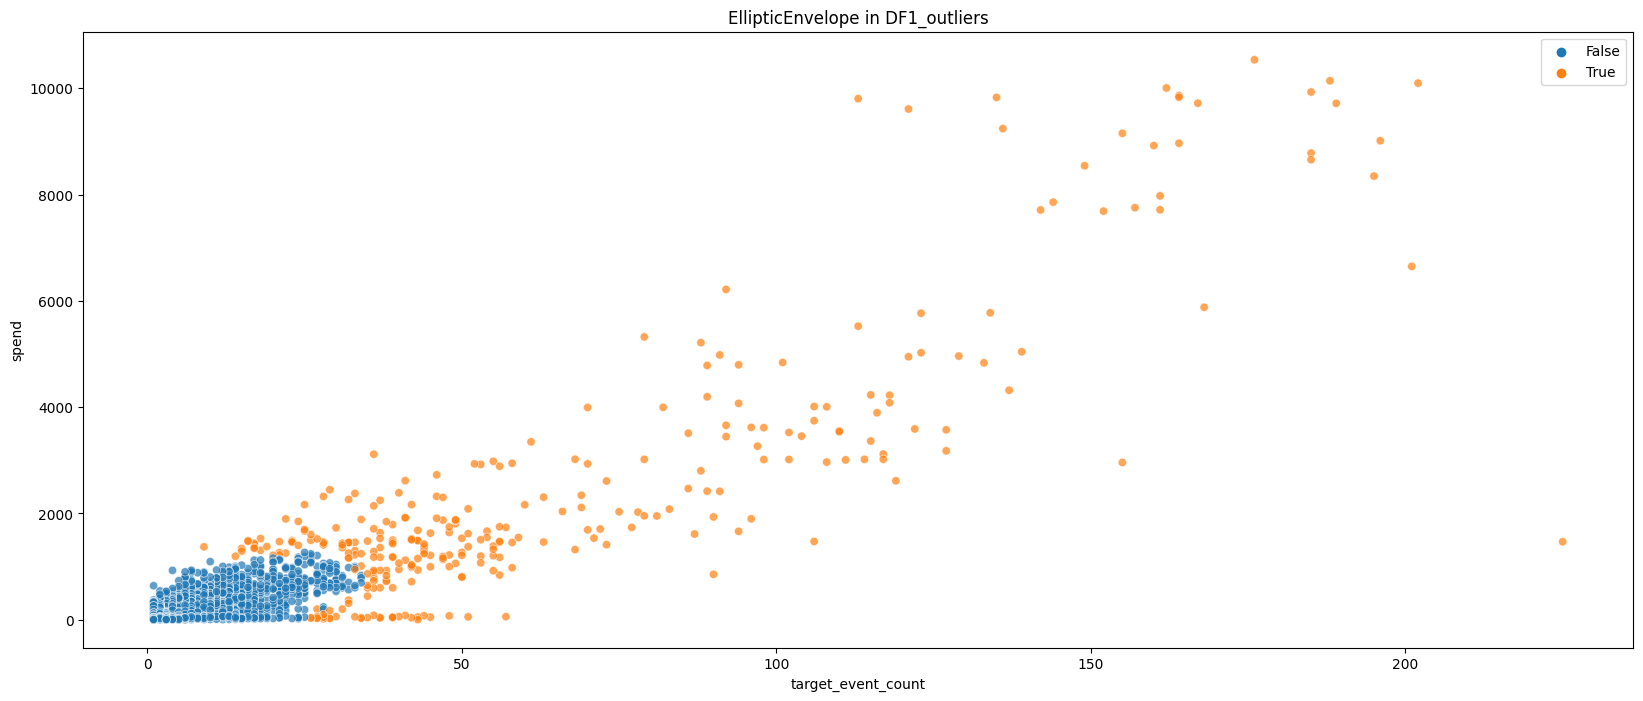

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=outliers1==-1, alpha=.7);
plt.title('EllipticEnvelope in DF1_outliers');

---------

## Isolation Forest

Utiliza el algoritmo de random forest. Este algoritmo aísla los datos seleccionando aleatoriamente una columna y luego un valor aleatorio dividido entre el max y mín de la misma. La partición aleatoria produce trayectorias más cortas para los valores atipicos

In [ ]:
clf = IsolationForest(random_state=42, 
                      n_estimators=100,
                      max_samples='auto',
                      bootstrap=True,
                      contamination=0.008,
                      n_jobs=-1,)

In [ ]:
outliers = clf.fit_predict(df_outliers)
outliers1 = clf.fit_predict(df1_outliers)

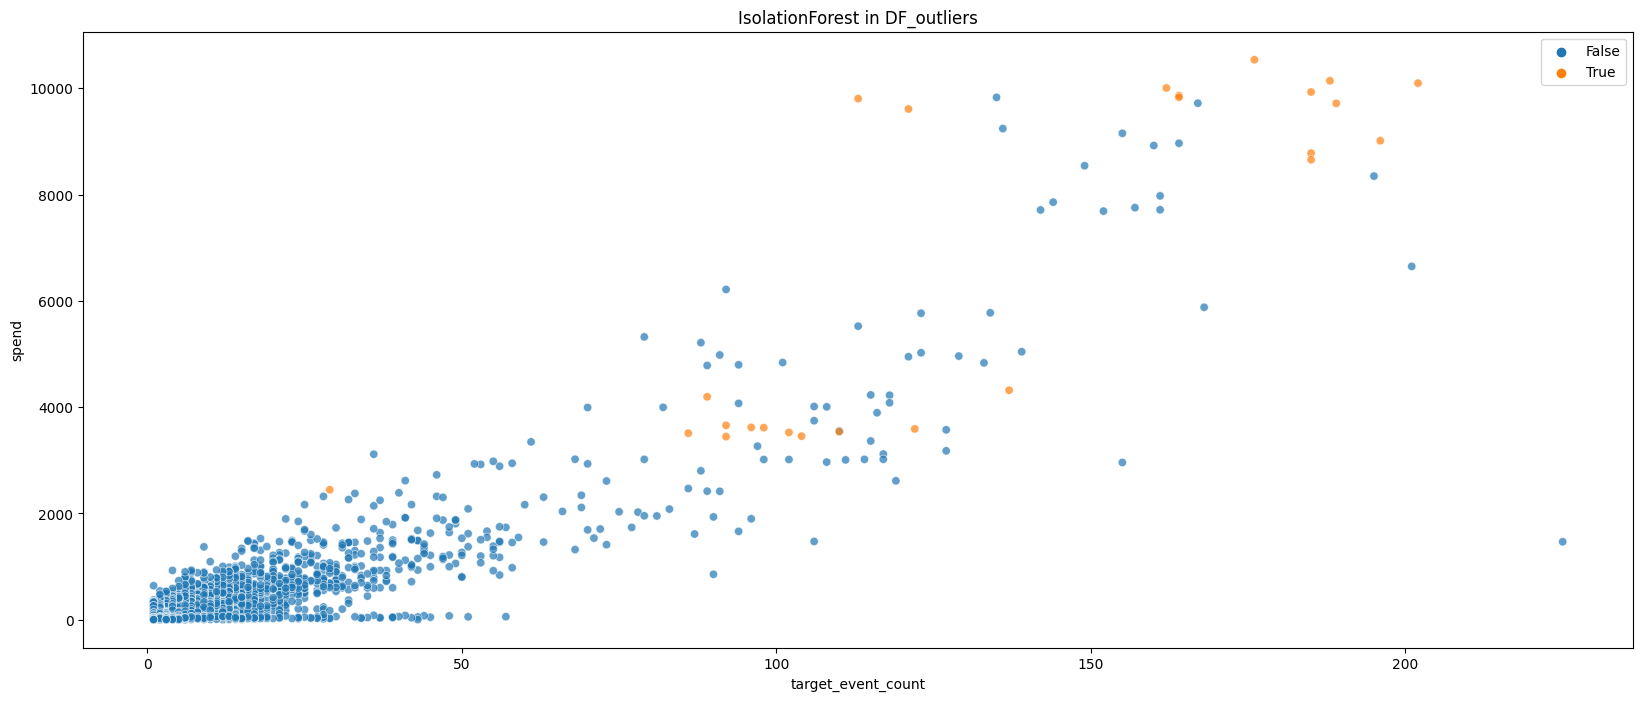

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=outliers==-1, alpha=.7);
plt.title('IsolationForest in DF_outliers');

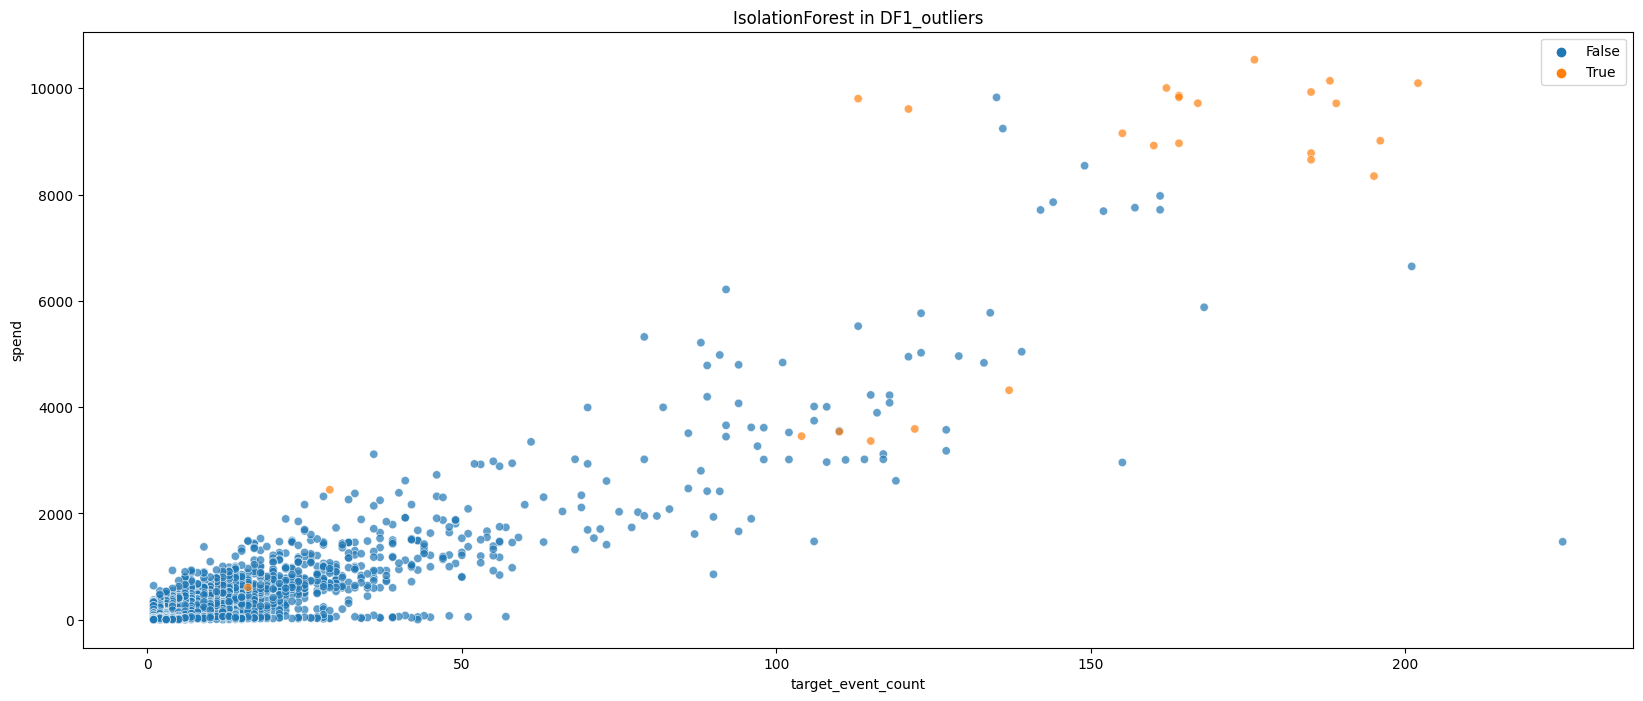

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=outliers1==-1, alpha=.7);
plt.title('IsolationForest in DF1_outliers');

--------------------

## DBSCAN

Es un algoritmo de agrupamiento basado en densidad porque encuentra un número de grupos (clusters) comenzando por una estimación de la distribución de densidad de los nodos correspondientes.

In [ ]:
dbscan = DBSCAN(eps=.000002,
                metric='correlation',
                min_samples=4,
                n_jobs=-1)

In [ ]:
dbscan.fit(df_outliers)

DBSCAN(algorithm='auto', eps=2e-06, leaf_size=30, metric='correlation',
       metric_params=None, min_samples=4, n_jobs=-1, p=None)

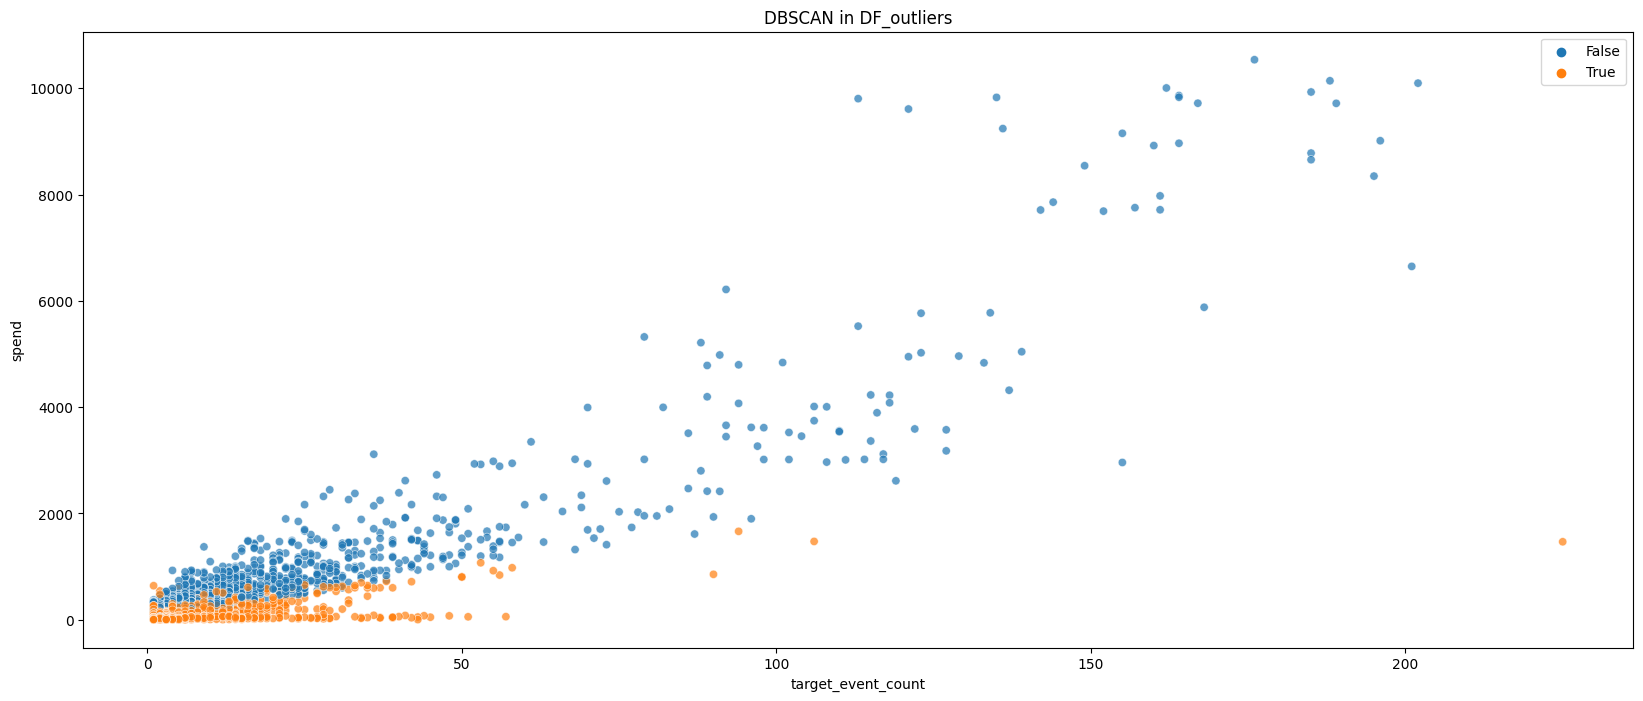

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=dbscan.labels_==-1, alpha=.7);
plt.title('DBSCAN in DF_outliers');

In [ ]:
dbscan.fit(df1_outliers)

DBSCAN(algorithm='auto', eps=2e-06, leaf_size=30, metric='correlation',
       metric_params=None, min_samples=4, n_jobs=-1, p=None)

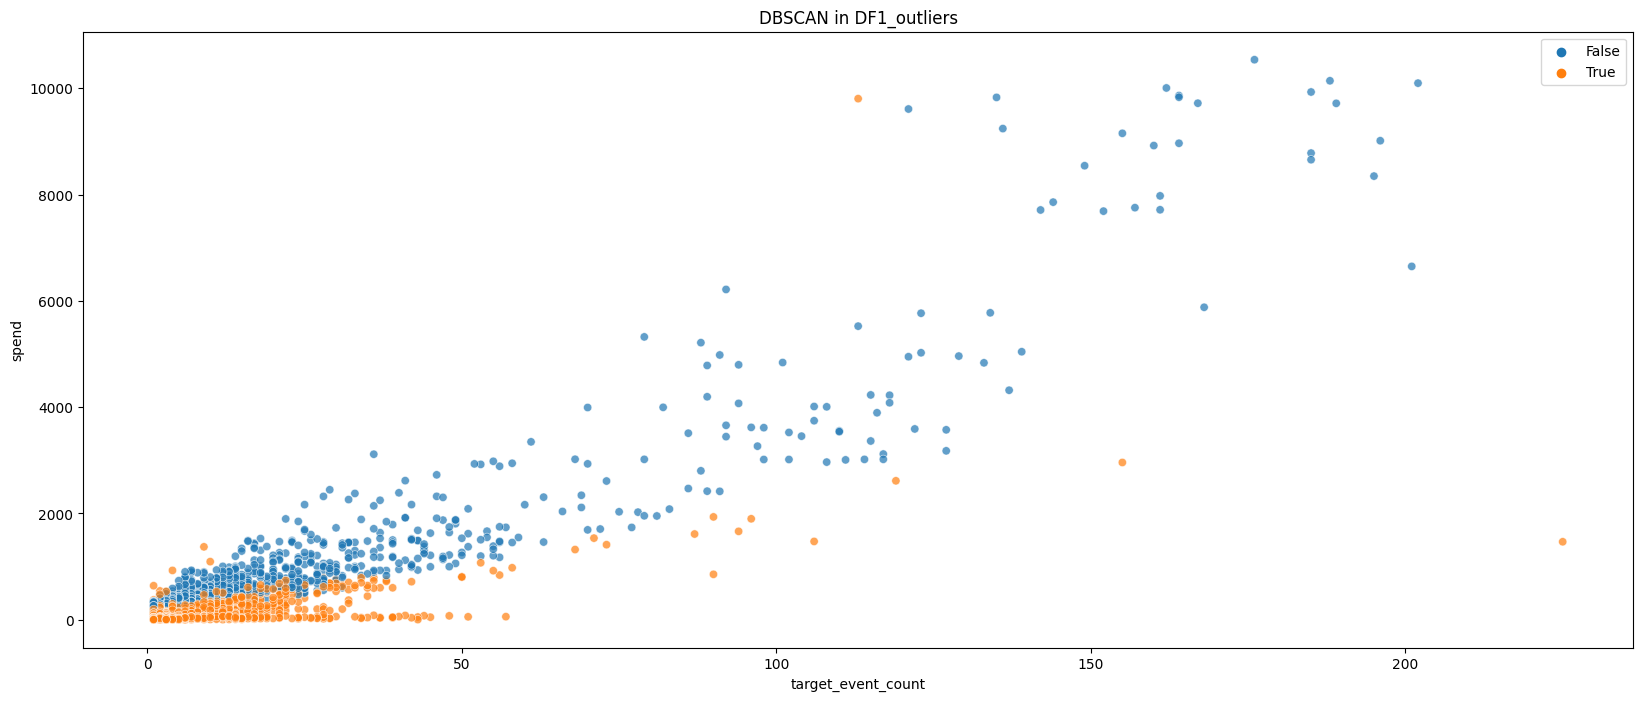

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x=data.target_event_count, y=data.spend, hue=dbscan.labels_==-1, alpha=.7);
plt.title('DBSCAN in DF1_outliers');

----------

## Conclusion
A partir de los modelos realizados, podemos decir, que los que mejor se desempeñaron fueron el *DBSCAN* y el *OneClassSVM* para el dataframe generado con la columna month en valores one hot encoding o dummies (df1_outliers). Ya que se clasifican observaciones como outliers o valores atipicos para aquellos donde los gastos (`spend`) son altos pero la cantidad de sucesos (`target_event_count`) son bajos o, los gastos (`spend`) son bajos pero la cantidad de sucesos (`target_event_count`) son altos.

------

In [ ]:
data['is_outlier'] = outliers1

Se agrega una nueva columna denominada `is_outlier` al dataset original donde:


> **-1**  ---> es outlier o valor atipico


> **1** ----> valor normal






In [ ]:
data

,app_id,timestamp,platform,country,media_source,spend,spend_currency,target_event_count,is_outlier
0,winclap.com,9/12/20,android,AU,pinterest,100.00,USD,2,1
1,winclap.com,12/6/20,android,AU,pinterest,300.00,USD,9,1
2,winclap.com,12/5/20,android,AU,pinterest,300.00,USD,1,1
3,winclap.com,12/4/20,android,AU,pinterest,300.00,USD,5,1
4,winclap.com,9/11/20,android,AU,pinterest,100.00,USD,2,1
...,...,...,...,...,...,...,...,...,...
3113,winclap.com,9/13/20,android,UK,google,2.37,USD,1,1
3114,winclap.com,9/12/20,android,UK,google,2.22,USD,3,1
3115,winclap.com,9/11/20,android,UK,google,6.03,USD,4,1
3116,winclap.com,9/10/20,android,UK,google,3.44,USD,3,1


In [ ]:
data[data.is_outlier==-1]

,app_id,timestamp,platform,country,media_source,spend,spend_currency,target_event_count,is_outlier
620,winclap.com,12/2/20,android,AU,facebook,10096.13,USD,202,-1
622,winclap.com,11/22/20,android,AU,facebook,9012.60,USD,196,-1
623,winclap.com,11/19/20,android,AU,facebook,8347.11,USD,195,-1
624,winclap.com,11/29/20,android,AU,facebook,9716.39,USD,189,-1
625,winclap.com,12/1/20,android,AU,facebook,10140.58,USD,188,-1
626,winclap.com,12/3/20,android,AU,facebook,9929.46,USD,185,-1
627,winclap.com,11/24/20,android,AU,facebook,8780.01,USD,185,-1
628,winclap.com,11/23/20,android,AU,facebook,8655.45,USD,185,-1
629,winclap.com,12/5/20,android,AU,facebook,10536.78,USD,176,-1
631,winclap.com,11/30/20,android,AU,facebook,9718.74,USD,167,-1


In [ ]:
# Se guarda el nuevo dataset con la columna que marca los valores atipicos

# data.to_csv('Dataset_cleaned')

In [ ]:
# Se guarda el modelo dbscan 

with open('dbscan.pk', 'wb') as fp:
    pickle.dump(dbscan, fp)